# Chapter 11: Bayesian statistics

In [1]:
library(tidyverse)
library(ggplot2)
library(cowplot)
library(boot)
library(MASS)
library(BayesFactor)
library(knitr)
theme_set(theme_minimal(base_size = 14))

set.seed(123456) # set random seed to exactly replicate results

# load the NHANES data library
library(NHANES)

# drop duplicated IDs within the NHANES dataset
NHANES <-
  NHANES %>%
  dplyr::distinct(ID, .keep_all = TRUE)

NHANES_adult <-
  NHANES %>%
  drop_na(Weight) %>%
  subset(Age >= 18)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: coda

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


************
Welcome to BayesFactor 0.9.12-4.4. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************



## Doing Bayesian estimation

In [2]:
bayes_df = data.frame(prior=NA,
                      likelihood=NA,
                      marginal_likelihood=NA,
                      posterior=NA)

bayes_df$prior <- 1/1000000


nTests <- 3
nPositives <- 3
sensitivity <- 0.99
specificity <- 0.99

bayes_df$likelihood <- dbinom(nPositives, nTests, 0.99)

bayes_df$marginal_likelihood <-
  dbinom(
    x = nPositives,
    size = nTests,
    prob = sensitivity
  ) * bayes_df$prior +
  dbinom(
    x = nPositives,
    size = nTests,
    prob = 1 - specificity
  ) *
  (1 - bayes_df$prior)

bayes_df$posterior <- (bayes_df$likelihood * bayes_df$prior) / bayes_df$marginal_likelihood

## Figure 11.2

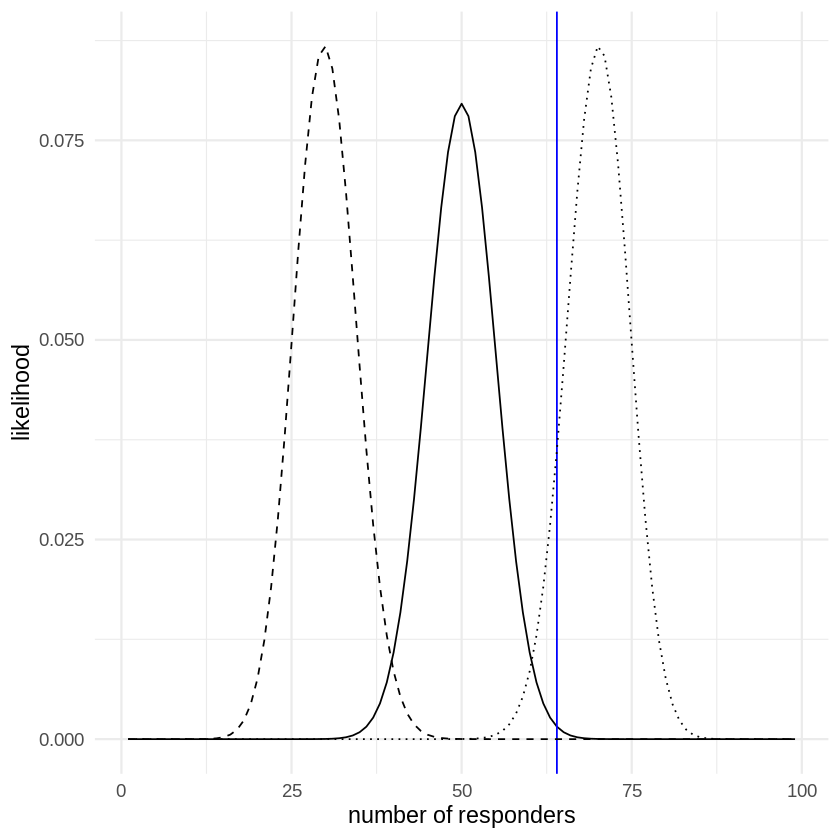

In [3]:
# create a table with results
nResponders <- 64
nTested <- 100

drugDf <- tibble(
  outcome = c("improved", "not improved"),
  number = c(nResponders, nTested - nResponders)
)

likeDf <-
  tibble(resp = seq(1,99,1)) %>%
  mutate(
    presp=resp/100,
    likelihood5 = dbinom(resp,100,.5),
    likelihood7 = dbinom(resp,100,.7),
    likelihood3 = dbinom(resp,100,.3)
)

ggplot(likeDf,aes(resp,likelihood5)) +
  geom_line() +
  xlab('number of responders') + ylab('likelihood') +
  geom_vline(xintercept = drugDf$number[1],color='blue') +
  geom_line(aes(resp,likelihood7),linetype='dotted') +
  geom_line(aes(resp,likelihood3),linetype='dashed')

## Figure 11.3

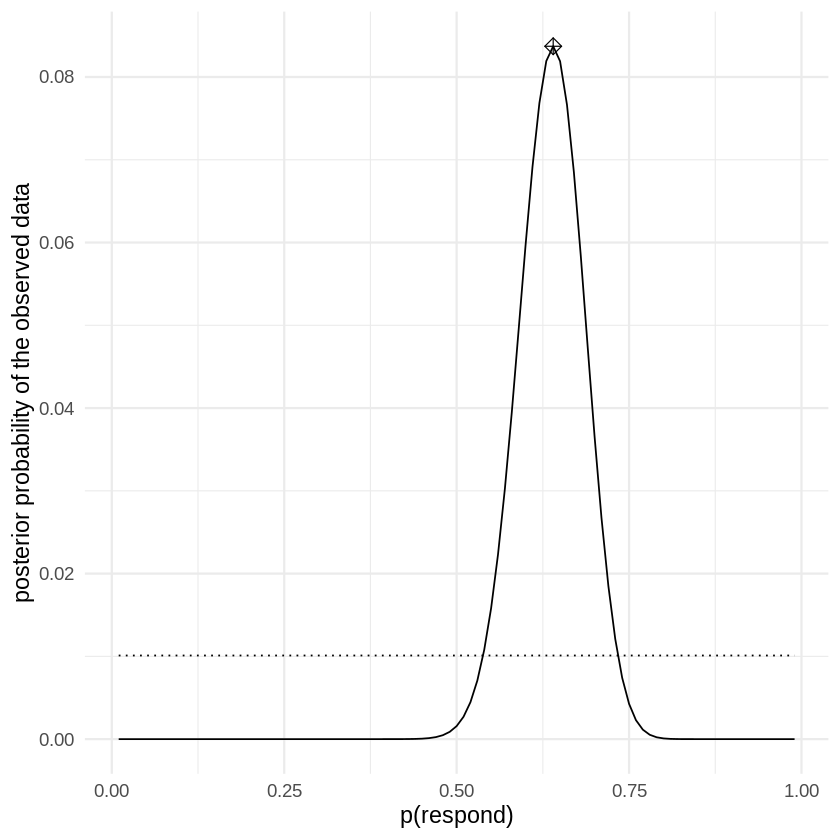

In [4]:
# compute marginal likelihood
likeDf <-
  likeDf %>%
  mutate(uniform_prior = array(1 / n()))

# multiply each likelihood by prior and add them up
marginal_likelihood <-
  sum(
    dbinom(
      x = nResponders, # the number who responded to the drug
      size = 100, # the number tested
      likeDf$presp # the likelihood of each response
    ) * likeDf$uniform_prior
  )

# Create data for use in figure
bayesDf <-
  tibble(
    steps = seq(from = 0.01, to = 0.99, by = 0.01)
  ) %>%
  mutate(
    likelihoods = dbinom(
      x = nResponders,
      size = 100,
      prob = steps
    ),
    priors = dunif(steps) / length(steps),
    posteriors = (likelihoods * priors) / marginal_likelihood
  )

# compute MAP estimate
MAP_estimate <-
  bayesDf %>%
  arrange(desc(posteriors)) %>%
  slice(1) %>%
  pull(steps)


# compute likelihoods for the observed data under all values of p(heads).  here we use the quantized values from .01 to .99 in steps of 0.01


ggplot(bayesDf,aes(steps,posteriors)) +
  geom_line() +
  geom_line(aes(steps,priors),color='black',linetype='dotted') +
  xlab('p(respond)') + ylab('posterior probability of the observed data') +
  annotate(
    "point",
    x = MAP_estimate,
    y = max(bayesDf$posteriors), shape=9,
    size = 3
  )

## Figure 11.4

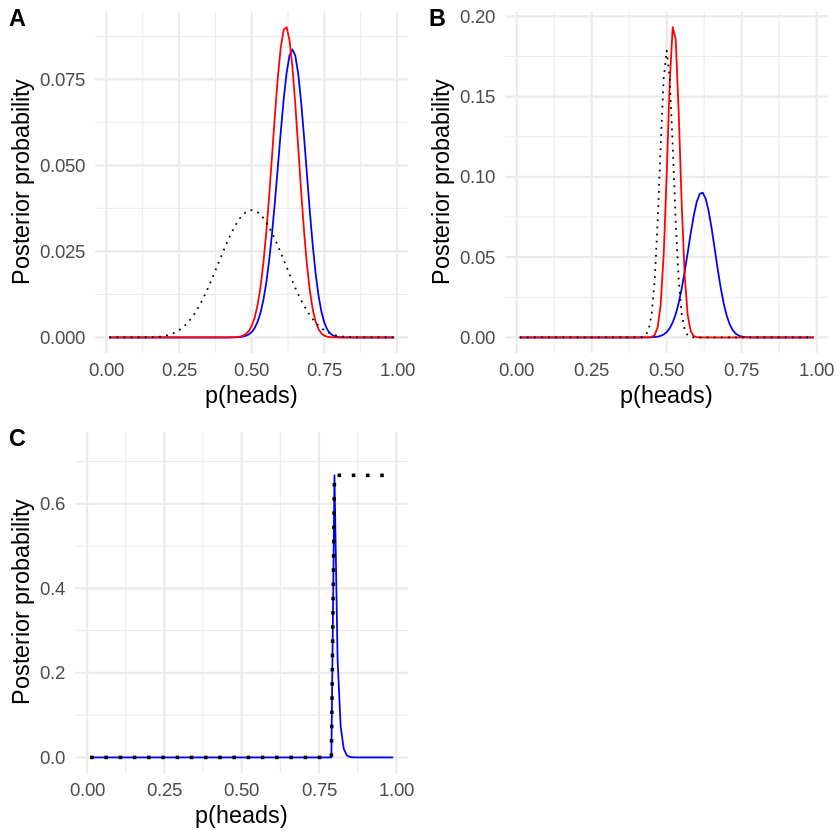

In [12]:
# compute likelihoods for data under all values of p(heads)
# using a flat or empirical prior.
# here we use the quantized values from .01 to .99 in steps of 0.01

df <-
  tibble(
    steps = seq(from = 0.01, to = 0.99, by = 0.01)
  ) %>%
  mutate(
    likelihoods = dbinom(nResponders, 100, steps),
    priors_flat = dunif(steps) / sum(dunif(steps)),
    priors_empirical = dbinom(10, 20, steps) / sum(dbinom(10, 20, steps))
  )

marginal_likelihood_flat <-
  sum(dbinom(nResponders, 100, df$steps) * df$priors_flat)

marginal_likelihood_empirical <-
  sum(dbinom(nResponders, 100, df$steps) * df$priors_empirical)

df <-
  df %>%
  mutate(
    posteriors_flat =
      (likelihoods * priors_flat) / marginal_likelihood_flat,
    posteriors_empirical =
      (likelihoods * priors_empirical) / marginal_likelihood_empirical
  )

p1 <- ggplot(df, aes(steps, posteriors_flat)) +
  geom_line(color = "blue") +
  xlab("p(heads)") + ylab("Posterior probability") +
  geom_line(aes(steps, posteriors_empirical), color = "red") +
  geom_line(aes(steps, priors_empirical), linetype = "dotted")

# compute likelihoods for data under all values of p(heads) using strong prior.

df <-
  df %>%
  mutate(
    priors_strong = dbinom(250, 500, steps) / sum(dbinom(250, 500, steps))
  )

marginal_likelihood_strong <-
  sum(dbinom(nResponders, 100, df$steps) * df$priors_strong)

df <-
  df %>%
  mutate(
    posteriors_strongprior = (likelihoods * priors_strong) / marginal_likelihood_strong
  )

p2 <- ggplot(df,aes(steps,posteriors_empirical)) +
  geom_line(color='blue') +
  xlab('p(heads)') + ylab('Posterior probability') +
  geom_line(aes(steps,posteriors_strongprior),color='red') +
  geom_line(aes(steps,priors_strong),linetype='dotted')

# compute likelihoods for data under all values of p(respond) using absolute prior.
df <-
  df %>%
  mutate(
    priors_absolute = array(data = 0, dim = length(steps)),
    priors_absolute = if_else(
      steps >= 0.8,
      1, priors_absolute
    ),
    priors_absolute = priors_absolute / sum(priors_absolute)
  )

marginal_likelihood_absolute <-
  sum(dbinom(nResponders, 100, df$steps) * df$priors_absolute)

df <-
  df %>%
  mutate(
    posteriors_absolute =
      (likelihoods * priors_absolute) / marginal_likelihood_absolute
  )

p3 <- ggplot(df,aes(steps,posteriors_absolute)) +
  geom_line(color='blue') +
  xlab('p(heads)') +
  ylab('Posterior probability') +
  ylim(0,max(df$posteriors_absolute)*1.1) +
  geom_line(aes(steps,
            priors_absolute*max(posteriors_absolute)*20),
            linetype='dotted',
            linewidth=1)

plot_grid(p1, p2,p3, labels='AUTO')

## Figure 11.5

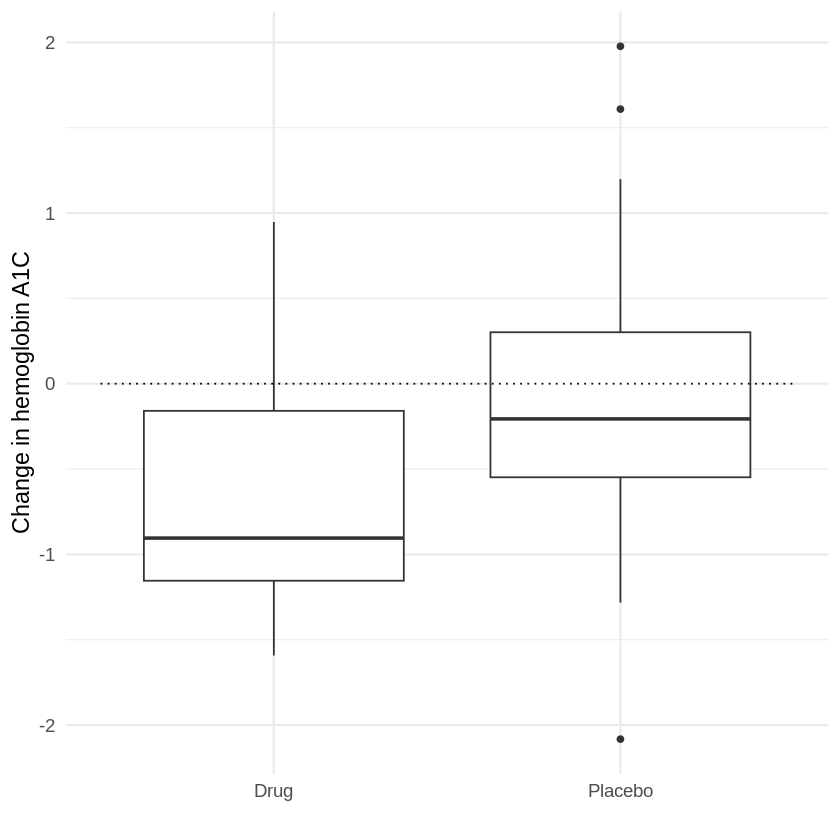

In [6]:
# create simulated data for drug trial example

set.seed(1234567)
nsubs <- 40
effect_size <- 0.6

# randomize indiviuals to drug (1) or placebo (0)
drugDf <-
  tibble(
    group = as.integer(runif(nsubs) > 0.5)
  ) %>%
  mutate(
    hbchange = rnorm(nsubs) - group * effect_size
  )

drugDf %>%
  mutate(
    group = as.factor(
      recode(
        group,
        "1" = "Drug",
        "0" = "Placebo"
      )
    )
  ) %>%
  ggplot(aes(group, hbchange)) +
  geom_boxplot() +
  annotate("segment", x = 0.5, xend = 2.5, y = 0, yend = 0, linetype = "dotted") +
  labs(
    x = "",
    y = "Change in hemoglobin A1C"
  )

## T-test for drug example

In [7]:
# compute t-test for drug example
drugTT <- t.test(hbchange ~ group, alternative = "greater", data = drugDf)
print(drugTT)


	Welch Two Sample t-test

data:  hbchange by group
t = 2.0813, df = 32.091, p-value = 0.02273
alternative hypothesis: true difference in means between group 0 and group 1 is greater than 0
95 percent confidence interval:
 0.1057051       Inf
sample estimates:
mean in group 0 mean in group 1 
    -0.08248954     -0.65013353 



## Bayes factor for drug example

In [8]:
# compute Bayes factor for drug data
bf_drug <- ttestBF(
  formula = hbchange ~ group, data = drugDf,
  nullInterval = c(0, Inf)
)

bf_drug

Warning message:
“data coerced from tibble to data frame”


Bayes factor analysis
--------------
[1] Alt., r=0.707 0<d<Inf    : 3.369297 ±0%
[2] Alt., r=0.707 !(0<d<Inf) : 0.115034 ±0.01%

Against denominator:
  Null, mu1-mu2 = 0 
---
Bayes factor type: BFindepSample, JZS


## Bayes factor for one-sided tests

In [9]:
bf_drug[1]/bf_drug[2]

Bayes factor analysis
--------------
[1] Alt., r=0.707 0<d<Inf : 29.28958 ±0.01%

Against denominator:
  Alternative, r = 0.707106781186548, mu =/= 0 !(0<d<Inf) 
---
Bayes factor type: BFindepSample, JZS


## Table 11.2

In [10]:
# Compute credible intervals for example

nsamples <- 100000

# create random uniform variates for x and y
x <- runif(nsamples)
y <- runif(nsamples)

# create f(x)
fx <- dbinom(x = nResponders, size = 100, prob = x)

# accept samples where y < f(x)
accept <- which(y < fx)
accepted_samples <- x[accept]

credible_interval <- quantile(x = accepted_samples,
                              probs = c(0.025, 0.975))
kable(credible_interval, caption='Credible interval obtained for the pain drug example using rejection sampling.')



Table: Credible interval obtained for the pain drug example using rejection sampling.

|      |         x|
|:-----|---------:|
|2.5%  | 0.5385021|
|97.5% | 0.7275576|

## Figure 11.6

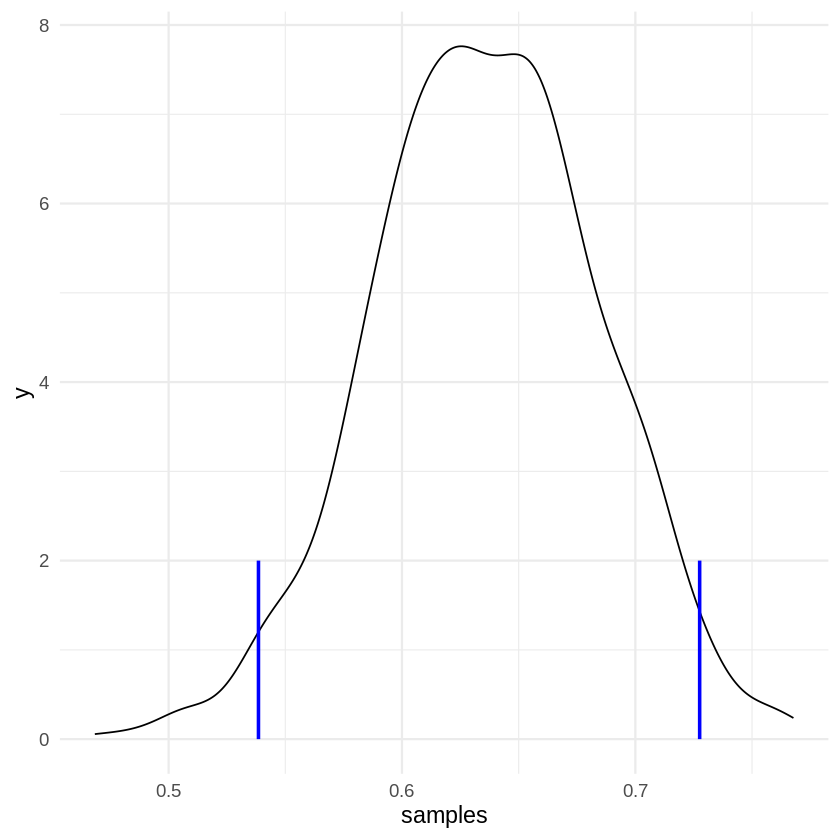

In [11]:
# plot histogram

p=ggplot(data.frame(samples=accepted_samples),aes(samples)) +
  geom_density()

for (i in 1:2) {
  p = p + annotate('segment',x=credible_interval[i],xend=credible_interval[i],
           y=0,yend=2,col='blue',lwd=1)
}
print(p)